# Project IND-320
**Name** : _Izza Qamar_

## Links
 - **GitHub Repository** : https://github.com/izzaqamar/Izza_Ind_320.git  

 - **Streamlit App** : https://izza-ind320.streamlit.app/

# Deliverable 3


## Project Overview and AI Usage 

### AI tools
I have used ***chatgpt*** on multiple occassions to understand different concepts. Initially to build a data dictionary, I used it to find latitude and longitude of different cities. Then, I used it to understand how I can plot SPC boundaries which follows the data more closely when doing dct filtering. Then I used it to read about STL using LOESS and Spectogram(how to deal when magnitude of column is large), what sort of data input they take and how we can plot the spectogram (especially how to get interval on x-axis in from of monthly ticks). 
For streamlit, I used it to understand how I can convert the selected area and respective data frame to session state. I also used it read about different UI elements and their essential use.

### Project Overview
This section contains brief desciption of jupyter notebook and streamlit app. 


#### Jupter Notebook
1. For this task, I created a jupyter notebook for deliverable-3 and set the right environment for it. Used matplotlib for jupyter tasks to extract the plots to pdf without disturbing the axis.

1. First task was to get data for selective variables from api for city of Bergen, a dictionary called 'data' was used for it and the data from api was stored in pandas df called 'df_beregn'.

1. Temperature Outliers: Imported dct,idct from scipy.fftpack. A fucntion called 'temp_outliers' with default values was used and then converted the temperature column to numpy array and performed dct filtering with type=2 and norm='ortho' and high pass filtering was perfomed and on that filtered data idct was applied to get back temp. values. Trimmed mean of 5% and std=3 was selected. These were used to find upper and lower bound which were then used to find outliers mask. It was then applied on original temp to find inliers and outliers. For plotting, we used low pass filtering to map SATV boundaries to original temperature scale and then we plotted the original temp. with outliers and boundaries of contrasting colors. Also added relevant summary.

1. Precipitation Anomalies: Imported LocalOutlierFactor from sklearn.neighbors. Created a function called precipiation anomalies with default value of outlier proportion= 1% (% of data to be outliers). Converted the precipitation column to 2D using list comprehension and then applied Local Outlier Factor and fiited the LOF model on the precipitation data which return an array 1 for inliers and -1 for outliers. Then the orignal data is plotted and the outliers mask are applied on original data to plot them. Relevant summary is also added.

1. Data from CSV: The data from csv is imported as pandas dataframe called 'production_df'. 

1. STL using LOESS: Imported STL from statsmodels.tsa.seasonal. Created a function called 'stl_loess' with default values default monthly period(720 hours) and True robust to have Stable trend and seasonal components. Then the 'production_df' is filtered on city area and production group. STL was performed on column 'quantity(kwh)'. No. of outliers was calculated and then customized the decomposition to different colors and sizes. The summmary describing each component was added.

1. Spectogram: Imported stft from scipy.signal. Created a function called 'plot_spectrogram' with default values of weekly changes. Then the 'production_df' is filtered on city area and production group. Then the column 'quantity(kwh)' is converted to numpy array. stft is applied with fs=24. To get a better view the t(interval) is used to get actual timestamps. As the values in some instance are large so used log(of magnitude) and used them to equate to 'vmin' and 'vmax'. For plotting, matplotlib was used. 2 plots containing actual data plot and spectogram are computed.

#### Streamlit app

1. Page order: A new page order was set depending on deliverable 3. Used plotly for all plots to make it interactive except spectogram.

1. Energy Production page: Same as deliverable-2. It contains the area selector which was updated to save its input to session state area. so that selected area is available on every page. The default area is equal to 'NO1'.

1. Page new A: It was added to read data from a csv file 'production.csv'. It has common(for both tabs) seperate area selector so user can also update session state area on this page and group selector. 2 Tabs are added where tab-1 has 'STL analysis' and tab-2 has 'Spectrogram'. For STL on tab-1 there are different UI elements such as sesional hour selelction and robust measure selection. For Spectogram on tab-2, user can select window length and window overlap.

1. Page FirstMonthInsight: It has initialized session state area and It has API CALL.The dataframe from api call is added to session state so that it is available to other pages. The year is selected as 2021. The page is updated according to this area and rest is same as deliverable-1.

1. Page Data Visualization: It contains a warning to get dataframe from page 4 and then run it. It will have same dataframe as in session state.

1. Page new B: Intialized that it should have same dataframe from page 4 which contains apicall , if not then it gives a warning.It has 2 tabs. Tab-1 contains Temp-Outlier/SPC analysis.It has 2 colums for each UI element. An input for dct cutoff hours and standard deviation respectively from user. Tab-2 contains Precipitation-Anomaly/LOF analysis. It has 2 columns for each slider. An input for outlier proportion and number of neighbors.


## Jupyter Work
- The following sections contain the jupyter tasks. 

In [8]:
import pandas as pd

data={
 'Oslo': {'PriceAreaCode': 'NO1', 'Longitude': 10.7461, 'Latitude': 59.9127},
 'Kristiansand': {'PriceAreaCode': 'NO2', 'Longitude': 7.9956, 'Latitude': 58.1467},
 'Trondheim': {'PriceAreaCode': 'NO3', 'Longitude': 10.3951, 'Latitude': 63.4305},
 'Tromsø': {'PriceAreaCode': 'NO4', 'Longitude': 18.9551, 'Latitude': 69.6489},
 'Bergen': {'PriceAreaCode': 'NO5', 'Longitude': 5.32415, 'Latitude': 60.39299}
}

df = pd.DataFrame(data)
print(df)


                  Oslo Kristiansand Trondheim   Tromsø    Bergen
PriceAreaCode      NO1          NO2       NO3      NO4       NO5
Longitude      10.7461       7.9956   10.3951  18.9551   5.32415
Latitude       59.9127      58.1467   63.4305  69.6489  60.39299


#### Data from API

In [9]:
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry
from datetime import date

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

def api_call(coords,year):
    Latitude,Longitude=coords
    start_date=date(year, 1, 1).strftime("%Y-%m-%d")
    end_date=date(year, 12, 31).strftime("%Y-%m-%d")
    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": Latitude,
        "longitude": Longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ["temperature_2m", "precipitation", "wind_speed_10m", "wind_gusts_10m", "wind_direction_10m"],
        "models": "era5",
    }
    responses = openmeteo.weather_api(url, params=params)
    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation: {response.Elevation()} m asl")
    print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")
    #print(f"Response:{response}")

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
    hourly_wind_speed_10m = hourly.Variables(2).ValuesAsNumpy()
    hourly_wind_gusts_10m = hourly.Variables(3).ValuesAsNumpy()
    hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()

    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}

    hourly_data["temperature_2m"] = hourly_temperature_2m
    hourly_data["precipitation"] = hourly_precipitation
    hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
    hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
    hourly_data["wind_direction_10m"] = hourly_wind_direction_10m

    hourly_dataframe = pd.DataFrame(data = hourly_data)
    #print("\nHourly_data\n", hourly_dataframe)
    return hourly_dataframe

coords=(data['Bergen']['Latitude'], data['Bergen']['Longitude'])
year=2019  
df_bergen=api_call(coords,year)
print(df_bergen.head())


Coordinates: 60.5°N 5.25°E
Elevation: 17.0 m asl
Timezone difference to GMT+0: 0s
                       date  temperature_2m  precipitation  wind_speed_10m  \
0 2019-01-01 00:00:00+00:00            6.55            0.5       47.959782   
1 2019-01-01 01:00:00+00:00            6.80            0.9       48.621330   
2 2019-01-01 02:00:00+00:00            6.85            0.7       52.638840   
3 2019-01-01 03:00:00+00:00            6.55            0.6       55.753529   
4 2019-01-01 04:00:00+00:00            6.20            1.0       55.531094   

   wind_gusts_10m  wind_direction_10m  
0       87.839996          277.765076  
1       80.279999          296.375275  
2       85.320000          310.006195  
3       98.639999          314.215271  
4      119.519997          317.101654  


#### Temperature Outliers

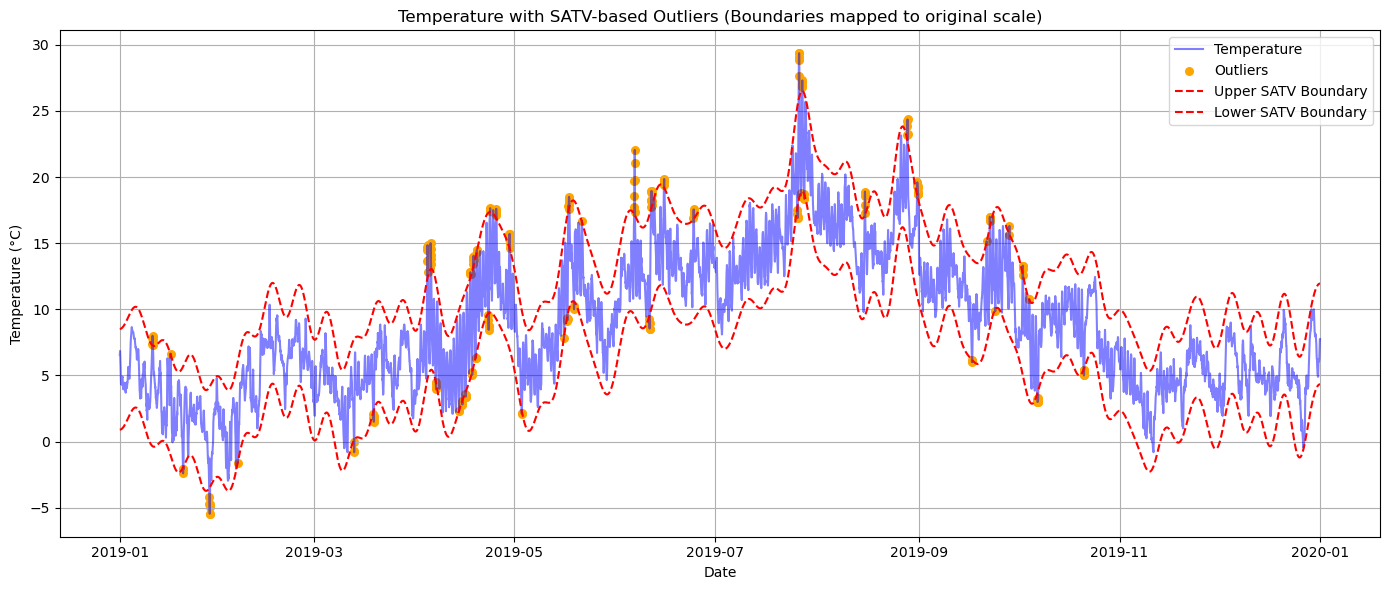

Summary 
    Trimmed mean (SATV): -0.01
    Trimmed std (SATV): 1.27
    Upper SPC bound (SATV): 3.80
    Lower SPC bound (SATV): -3.82
    Number of inliers: 8551
    Number of outliers: 209  


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
import scipy.stats as stats

def temp_outliers(dct_cutoff_hours=168,n_std=3):
    
    # Original temperature converted to numpy array to pass to dct
    temp = df_bergen['temperature_2m'].to_numpy(dtype=float)
    dates = pd.to_datetime(df_bergen['date'])

    #  DCT type 2
    N = len(temp)
    temp_dct = dct(temp, type=2, norm='ortho')

    # cutoff (default:weekly)
    k_cut = int(2 * N / dct_cutoff_hours)

    # High-pass filtering and SATV 
    temp_dct_hp = temp_dct.copy()
    temp_dct_hp[:k_cut] = 0
    temp_satv = idct(temp_dct_hp, type=2, norm='ortho')

    #5% of the most extreme values trimmed
    trim_proportion = 0.05
    n_std = 3

    trimmed_mean_val = stats.trim_mean(temp_satv, trim_proportion)
    sorted_data = np.sort(temp_satv)
    
    #Number of values to be trimmed
    cut = int(trim_proportion * N)
    #keeps 90% of middle values and gives trimmed std for population
    trimmed_std_val = np.std(sorted_data[cut:N-cut], ddof=0)

    #Calculating boundaries
    upper_bound = trimmed_mean_val + n_std * trimmed_std_val
    lower_bound = trimmed_mean_val - n_std * trimmed_std_val

    # Identifying outliers 
    outliers_mask = (temp_satv > upper_bound) | (temp_satv < lower_bound)
    inliers_mask = ~outliers_mask

    # original temperatures corresponding to inliers and outliers
    inliers = temp[inliers_mask]    
    outliers = temp[outliers_mask]  

    # To Map SATV boundaries to original temperature scale we find trend from Low-pass (slow) component extraction
    temp_dct_low = temp_dct.copy()
    temp_dct_low[k_cut:] = 0  
    temp_lowfreq = idct(temp_dct_low, type=2, norm='ortho') # trend
    
    # Reconstruction by adding the robust SPC bounds to the low-frequency component of the signal
    upper_thresh_orig = temp_lowfreq + upper_bound
    lower_thresh_orig = temp_lowfreq + lower_bound

    # Plotting original temperature with SATV-based outliers 
    fig=plt.figure(figsize=(14,6))
    plt.plot(dates, temp, color='blue', label='Temperature', alpha=0.5)
    plt.scatter(dates[outliers_mask], temp[outliers_mask], color='orange', s=30, label='Outliers')

    # Plotting dynamic SATV-based thresholds
    plt.plot(dates, upper_thresh_orig, color='red', linestyle='--', label='Upper SATV Boundary')
    plt.plot(dates, lower_thresh_orig, color='red', linestyle='--', label='Lower SATV Boundary')

    plt.title("Temperature with SATV-based Outliers (Boundaries mapped to original scale)")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    #  Summary 
    summary = f"""Summary 
    Trimmed mean (SATV): {trimmed_mean_val:.2f}
    Trimmed std (SATV): {trimmed_std_val:.2f}
    Upper SPC bound (SATV): {upper_bound:.2f}
    Lower SPC bound (SATV): {lower_bound:.2f}
    Number of inliers: {len(inliers)}
    Number of outliers: {len(outliers)}  """
    
    return plt,summary
#Testing the function
temp,summary=temp_outliers(dct_cutoff_hours=168,n_std=3) 
temp.show()
print(summary) 


#### Precipitation Anomalies

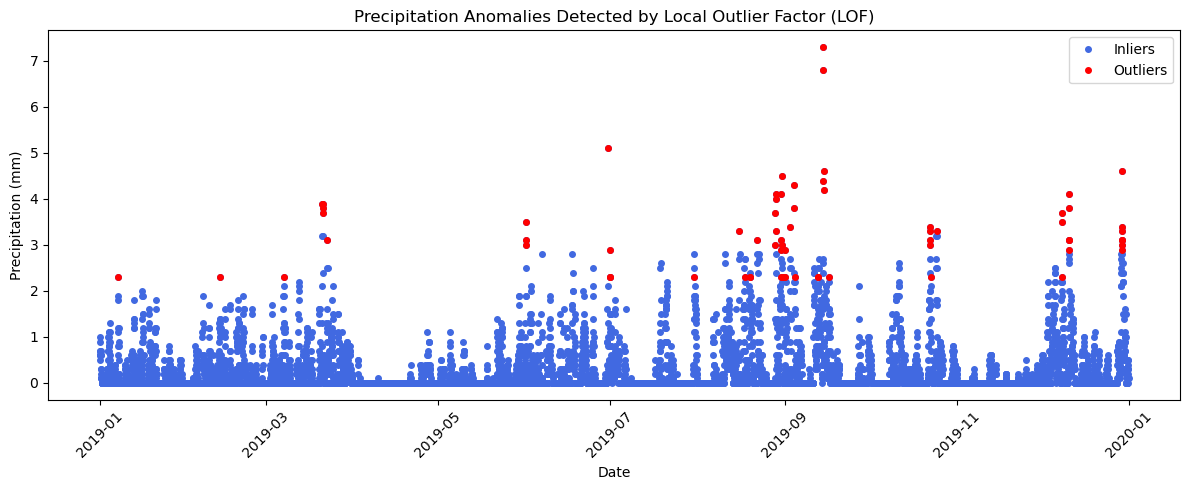

 Summary
      Proportion of outliers 0.01
      Number of inliers: 8692 
      Number of outliers: 68


In [11]:
from sklearn.neighbors import LocalOutlierFactor

def precipitation_anomalies(outlier_proportion=0.01):
    
    # Ensure data is in 2D shape for LOF
    precipitation = [[x] for x in df_bergen['precipitation']]

    # Apply Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors= 20, contamination=outlier_proportion)
    pred_labels = lof.fit_predict(precipitation)

    # LOF returns -1 for outliers and 1 for inliers (boolean values)
    outliers = pred_labels == -1
    inliers = pred_labels == 1

    # Plotting 
    fig = plt.figure(figsize=(12, 5))

    # Plot all data points (inliers in blue)
    plt.plot(df_bergen['date'], df_bergen['precipitation'], 'o', color='royalblue', markersize=4, label='Inliers')

    # Plot outliers (in red)
    plt.plot(df_bergen['date'][outliers], df_bergen['precipitation'][outliers], 
             'o', color='red', markersize=4, label='Outliers')

    # Axis labels and title
    plt.title('Precipitation Anomalies Detected by Local Outlier Factor (LOF)')
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Summary
    summary = f''' Summary
      Proportion of outliers {outlier_proportion}
      Number of inliers: {np.sum(inliers)} 
      Number of outliers: {np.sum(outliers)}'''

    return plt,summary
    #return fig,summary


#Testing the function
precipitation,summary = precipitation_anomalies(outlier_proportion=0.01)
precipitation.show()
print(summary)


#### Data from CSV

In [12]:
#Fetching data from csv for Seasonal-Trend decomposition and Spectrogram
#Reading csv as dataframe
production_df=pd.read_csv(r"production_elhub.csv",
                          parse_dates=['endTime','startTime','lastUpdatedTime'],
                          dtype={'priceArea': 'string', 'productionGroup': 'string'})

#Displaying descriptive statistics of dataframe 
print(production_df.info())
print(production_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215353 entries, 0 to 215352
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   endTime          215353 non-null  datetime64[ns, UTC]
 1   lastUpdatedTime  215353 non-null  datetime64[ns, UTC]
 2   priceArea        215353 non-null  string             
 3   productionGroup  215353 non-null  string             
 4   quantityKwh      215353 non-null  float64            
 5   startTime        215353 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](3), float64(1), string(2)
memory usage: 9.9 MB
None
                    endTime           lastUpdatedTime priceArea  \
0 2021-01-01 00:00:00+00:00 2024-12-20 09:35:40+00:00       NO1   
1 2021-01-01 01:00:00+00:00 2024-12-20 09:35:40+00:00       NO1   
2 2021-01-01 02:00:00+00:00 2024-12-20 09:35:40+00:00       NO1   
3 2021-01-01 03:00:00+00:00 2024-12-20 09:35:40+00:00       NO1   
4 2

#### LOESS

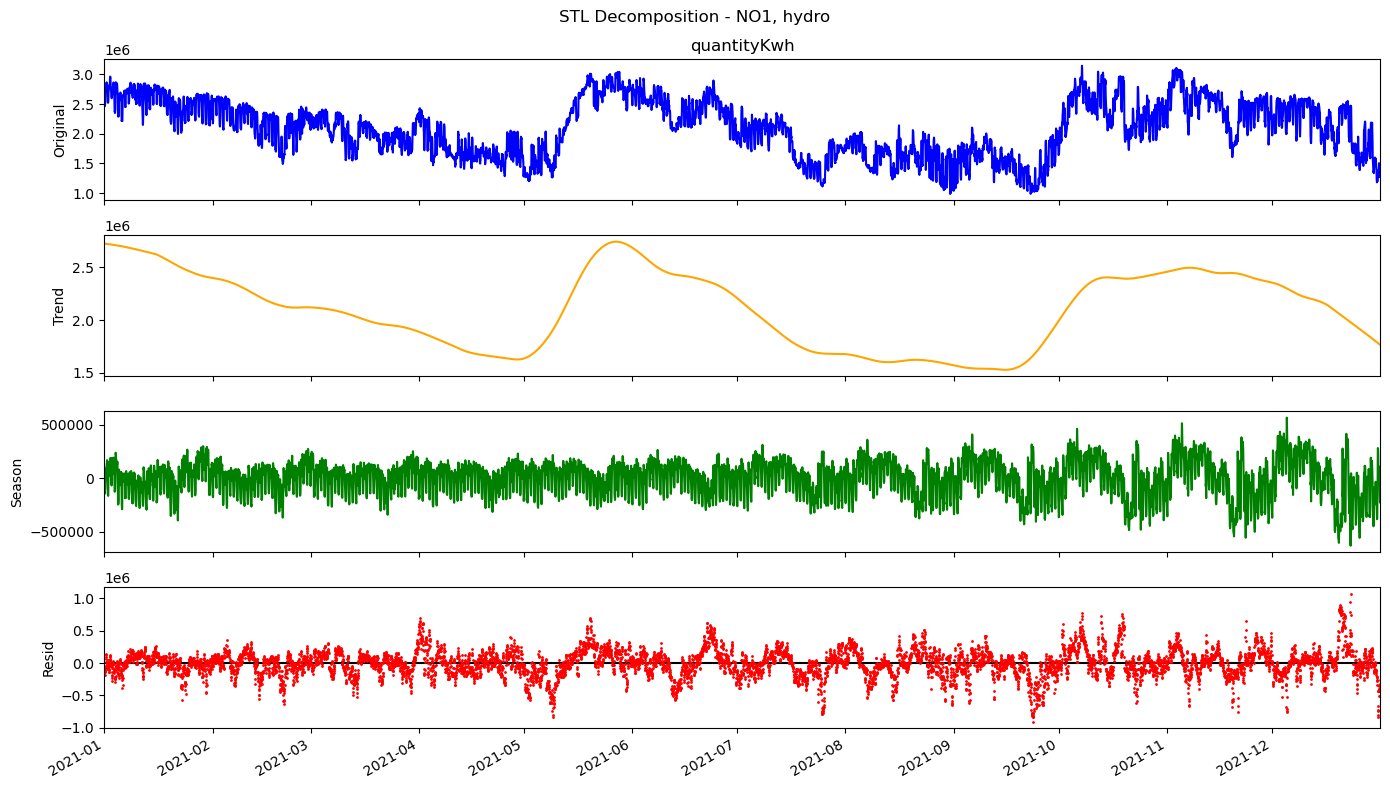

{'trend_stats': count    8.760000e+03
mean     2.102959e+06
std      3.595449e+05
min      1.528900e+06
25%      1.736638e+06
50%      2.120131e+06
75%      2.409068e+06
max      2.741706e+06
Name: trend, dtype: float64, 'seasonal_stats': count      8760.000000
mean      -4574.657409
std      164210.800282
min     -628917.275363
25%     -117312.420083
50%       18087.547539
75%      109906.100576
max      565831.534206
Name: season, dtype: float64, 'residual_stats': count    8.760000e+03
mean    -2.860789e+03
std      2.082866e+05
min     -9.057972e+05
25%     -1.223583e+05
50%      4.076046e+03
75%      1.161217e+05
max      1.075243e+06
Name: resid, dtype: float64, 'num_residual_outliers': 115}


In [15]:
#Performing Seasonal-Trend decomposition using LOESS (STL)
#Stable trend and seasonal components, especially with outliers → robust=True.
from statsmodels.tsa.seasonal import STL

#default monthly period and True robust
def stl_Loess(priceArea='NO1',productionGroup='hydro',period=720,
              seasonal_smoother=723,trend_smoother=723,robust=True):
    filtered_stl_df = production_df.copy()
    if priceArea is not None:
        filtered_stl_df = filtered_stl_df[filtered_stl_df['priceArea'] == priceArea]
    if productionGroup is not None:
        filtered_stl_df = filtered_stl_df[filtered_stl_df['productionGroup'] == productionGroup]
    
    # Setting datetime index
    filtered_stl_df = filtered_stl_df.set_index('startTime')

    stl = STL(filtered_stl_df["quantityKwh"], period=period, 
              seasonal=seasonal_smoother, trend=trend_smoother, robust=robust)
    
    # Contains the components and a plot function
    res = stl.fit() 
    fig = res.plot()
    
    # Compute residual outliers (3-sigma rule)
    threshold = 3 * np.std(res.resid)
    outliers = (res.resid > threshold) | (res.resid < -threshold)
    
    #Resizing figure 
    fig.set_size_inches(14, 8)   
    fig.autofmt_xdate()
   
    # Get all Axes (subplots) from the figure to recolour individually
    axes = fig.get_axes()
    
    axes[0].lines[0].set_color("blue")
    axes[0].set_ylabel("Original")      
    
    axes[1].lines[0].set_color("orange")    
    
    axes[2].lines[0].set_color("green")     
    
    axes[3].lines[0].set_color("red")  
    axes[3].lines[0].set_markersize(1) 
    
    plt.suptitle(f"STL Decomposition - {priceArea}, {productionGroup}", fontsize=12)
    plt.tight_layout()
    summary = {
    "trend_stats": res.trend.describe(),
    "seasonal_stats": res.seasonal.describe(),
    "residual_stats": res.resid.describe(),
    "num_residual_outliers": outliers.sum()}
    
    return fig,res,summary
#Testing the function
fig, decomposition,info = stl_Loess(priceArea='NO1',productionGroup='hydro',period=720,
                                    seasonal_smoother=723,trend_smoother=723,robust=True)
plt.show()  
print(info)

#### Spectogram

 Summary:
    Max magnitude: 2827460.9969476527
    Min of log1p(magnitude: 2.4735216602872603
    Max of log1p(magnitude: 14.854890046368437


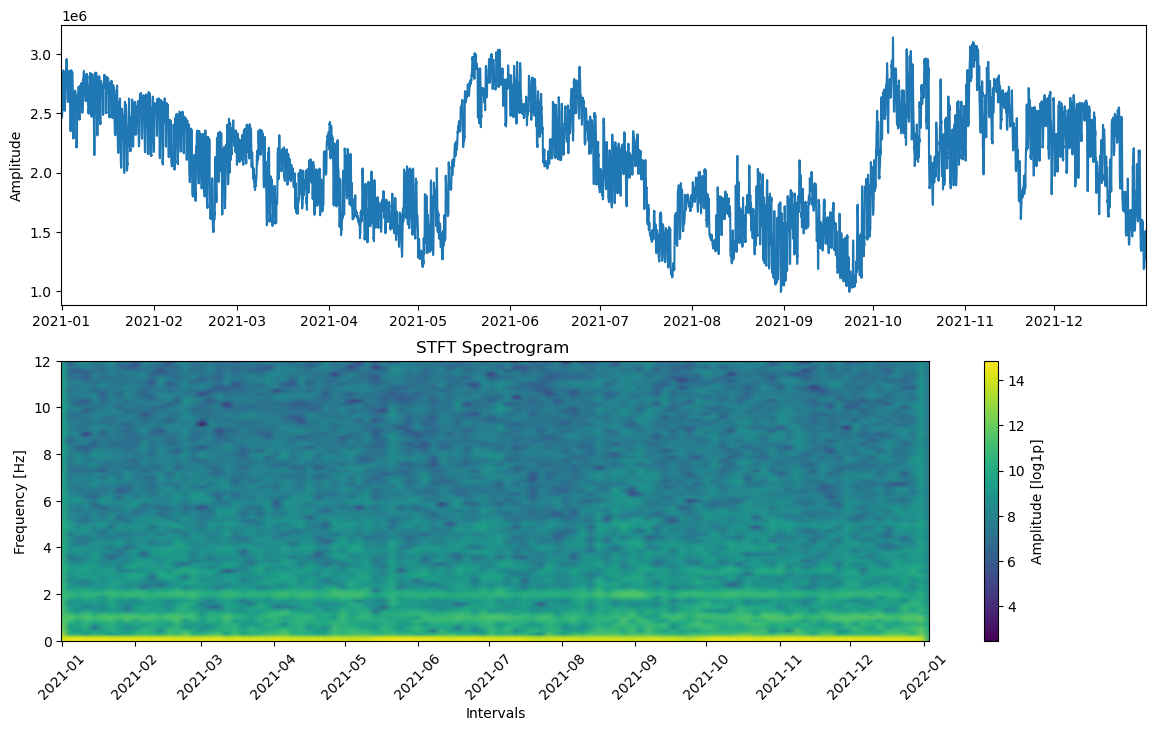

In [14]:
from scipy.signal import stft
import matplotlib.dates as mdates

#Creating function to compute spectogram through stft
# Window length: Default Weekly changes
# Window overlap: 50% of overlap allowed
#fs=24 i.e 24 hour per day (samples per day)
def plot_spectrogram(priceArea='NO1',productionGroup='hydro', window_length=168, window_overlap=84):
    df_spectogram = production_df.copy()
    if priceArea is not None:
        df_spectogram = df_spectogram[df_spectogram['priceArea'] == priceArea]
    if productionGroup is not None:
        df_spectogram = df_spectogram[df_spectogram['productionGroup'] == productionGroup]
        
    data=df_spectogram["quantityKwh"].to_numpy()
    fs = 24      # samples per day
    
    # Compute spectrogram
    f, t, Zxx = stft(data, fs=fs, nperseg=window_length, noverlap=window_overlap)
    
    # Convert t to actual timestamps
    time_index = df_spectogram.set_index('startTime').index
    t_dates = time_index[0] + pd.to_timedelta(t, unit='D')

    # Compute min and max of log_magnitude to set vmin and vmax
    magnitude = np.abs(Zxx)
    log_magnitude = np.log1p(magnitude)
    log_min = np.min(log_magnitude)
    log_max = np.max(log_magnitude)
    
    # Plot the data and the spectrogram above each other
    fig, axs = plt.subplots(2, 1)
    fig.set_size_inches(14,8)
    axs[0].plot(time_index,data)
    axs[0].set_xlim(time_index[0], time_index[-1])
    axs[0].set_ylabel('Amplitude')
    
    pcm1 = axs[1].pcolormesh(t_dates, f,log_magnitude,shading='gouraud',vmin=log_min , vmax=log_max)
    axs[1].set_ylabel('Frequency [Hz]')
    axs[1].set_xlabel('Intervals')
    axs[1].set_title('STFT Spectrogram ')
    fig.colorbar(pcm1, ax=axs[1], label='Amplitude [log1p]')
    
    # Formatting x-axis to show monthly ticks
    axs[1].xaxis.set_major_locator(mdates.MonthLocator())  # Tick every month
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)
    
    summary=print(f""" Summary:
    Max magnitude: {np.max(magnitude)}
    Min of log1p(magnitude: {log_min}
    Max of log1p(magnitude: {log_max}""")

    return fig,summary

# Call the function
fig,summary = plot_spectrogram(priceArea='NO1', productionGroup='hydro', 
                              window_length=168, window_overlap=84)
plt.show()
        
